In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [5]:
mspec_train_x = np.load("mspec_train_x_dy.npz")["X"]
mspec_val_x   = np.load("mspec_val_x_dy.npz")["X"]

train_y = np.load("train_y_dy.npz")["y"]
val_y   = np.load("val_y_dy.npz")["y"]


train_x = torch.tensor(mspec_train_x, dtype=torch.float32)
val_x   = torch.tensor(mspec_val_x, dtype=torch.float32)


train_y = torch.tensor(train_y, dtype=torch.long)
val_y   = torch.tensor(val_y, dtype=torch.long)

# add noise to the training data
noise_std = 0.01
augmented_train_x = train_x + noise_std * torch.randn_like(train_x)

input_dim = mspec_train_x.shape[1]
hidden_dim = 256
output_dim = len(torch.unique(train_y))
batch_size = 256
num_epochs = 100
learning_rate = 1e-3
patience = 3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_loader = DataLoader(TensorDataset(augmented_train_x, train_y), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(val_x, val_y),     batch_size=batch_size)

writer = SummaryWriter()

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    accuracy = correct / total

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {accuracy:.4f}")
    writer.add_scalars("Loss", {"Train": train_loss, "Val": val_loss}, epoch)
    writer.add_scalar("Accuracy/Val", accuracy, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(net.state_dict(), "model_mspec_dy_2layer.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


Epoch 1: Train Loss = 0.9074, Val Loss = 0.7837, Val Acc = 0.7396
Epoch 2: Train Loss = 0.6901, Val Loss = 0.7231, Val Acc = 0.7598
Epoch 3: Train Loss = 0.6409, Val Loss = 0.7064, Val Acc = 0.7680
Epoch 4: Train Loss = 0.6127, Val Loss = 0.6868, Val Acc = 0.7723
Epoch 5: Train Loss = 0.5950, Val Loss = 0.7078, Val Acc = 0.7681
Epoch 6: Train Loss = 0.5814, Val Loss = 0.6896, Val Acc = 0.7720
Epoch 7: Train Loss = 0.5721, Val Loss = 0.6643, Val Acc = 0.7787
Epoch 8: Train Loss = 0.5650, Val Loss = 0.6616, Val Acc = 0.7791
Epoch 9: Train Loss = 0.5584, Val Loss = 0.6727, Val Acc = 0.7792
Epoch 10: Train Loss = 0.5529, Val Loss = 0.6746, Val Acc = 0.7794
Epoch 11: Train Loss = 0.5472, Val Loss = 0.6595, Val Acc = 0.7843
Epoch 12: Train Loss = 0.5435, Val Loss = 0.6532, Val Acc = 0.7835
Epoch 13: Train Loss = 0.5395, Val Loss = 0.6591, Val Acc = 0.7814
Epoch 14: Train Loss = 0.5367, Val Loss = 0.6802, Val Acc = 0.7809
Epoch 15: Train Loss = 0.5335, Val Loss = 0.6516, Val Acc = 0.7864
Epoc

In [6]:
mspec_test_x = np.load("mspec_test_x_dy.npz")['X']
test_y = np.load("test_y_dy.npz")['y']

test_x_tensor = torch.tensor(mspec_test_x, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.long)

net.eval()

with torch.no_grad():
    outputs = net(test_x_tensor)
    _, predicted = torch.max(outputs, 1)


In [7]:
accuracy = (predicted == test_y_tensor).sum() / len(test_y_tensor)
print(f" frame-by-frame at the state level accuracy: {accuracy:.4f}")


 frame-by-frame at the state level accuracy: 0.7667


In [8]:
phoneHMMs = np.load('../../lab2/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
stateList

['ah_0',
 'ah_1',
 'ah_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'eh_0',
 'eh_1',
 'eh_2',
 'ey_0',
 'ey_1',
 'ey_2',
 'f_0',
 'f_1',
 'f_2',
 'ih_0',
 'ih_1',
 'ih_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'k_0',
 'k_1',
 'k_2',
 'n_0',
 'n_1',
 'n_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'r_0',
 'r_1',
 'r_2',
 's_0',
 's_1',
 's_2',
 'sil_0',
 'sil_1',
 'sil_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'th_0',
 'th_1',
 'th_2',
 'uw_0',
 'uw_1',
 'uw_2',
 'v_0',
 'v_1',
 'v_2',
 'w_0',
 'w_1',
 'w_2',
 'z_0',
 'z_1',
 'z_2']

In [9]:
len(stateList)

61

In [10]:
example_input = test_x_tensor[0:80]
example_target = test_y[0:80]

with torch.no_grad():
    output_frame = net(example_input)
    posteriors = F.softmax(output_frame, 1).numpy()
posteriors[0]

array([5.2472882e-07, 6.3571980e-07, 3.3123655e-07, 8.1926000e-06,
       7.9413430e-06, 3.3779008e-06, 1.5955054e-06, 2.9544369e-06,
       3.7647180e-06, 3.5537532e-06, 2.0590605e-06, 1.7118289e-06,
       9.7979253e-05, 1.0550566e-06, 5.7390395e-07, 1.6140897e-04,
       5.6431497e-07, 3.4612258e-06, 3.0230574e-06, 1.2623726e-06,
       1.0966575e-06, 2.2969166e-06, 3.5722890e-06, 3.3705319e-06,
       2.0738489e-06, 5.4961984e-04, 1.3347269e-06, 1.0337436e-06,
       1.8746940e-06, 3.7859409e-05, 5.1748834e-06, 1.5478984e-06,
       1.0940397e-06, 2.9349278e-06, 9.2758251e-07, 7.0074719e-07,
       1.6459484e-04, 5.2281143e-06, 3.1337771e-05, 6.4262837e-02,
       8.4579641e-01, 4.0084817e-02, 4.8008766e-02, 4.8047557e-04,
       1.0100180e-05, 5.3097010e-06, 1.6827423e-04, 3.2037750e-07,
       1.2259454e-06, 1.6885647e-06, 9.6356416e-07, 3.5870196e-06,
       6.4910637e-07, 1.1747456e-06, 3.4259388e-06, 7.7885152e-06,
       2.4071329e-07, 2.3230548e-06, 3.3550856e-05, 6.2887517e

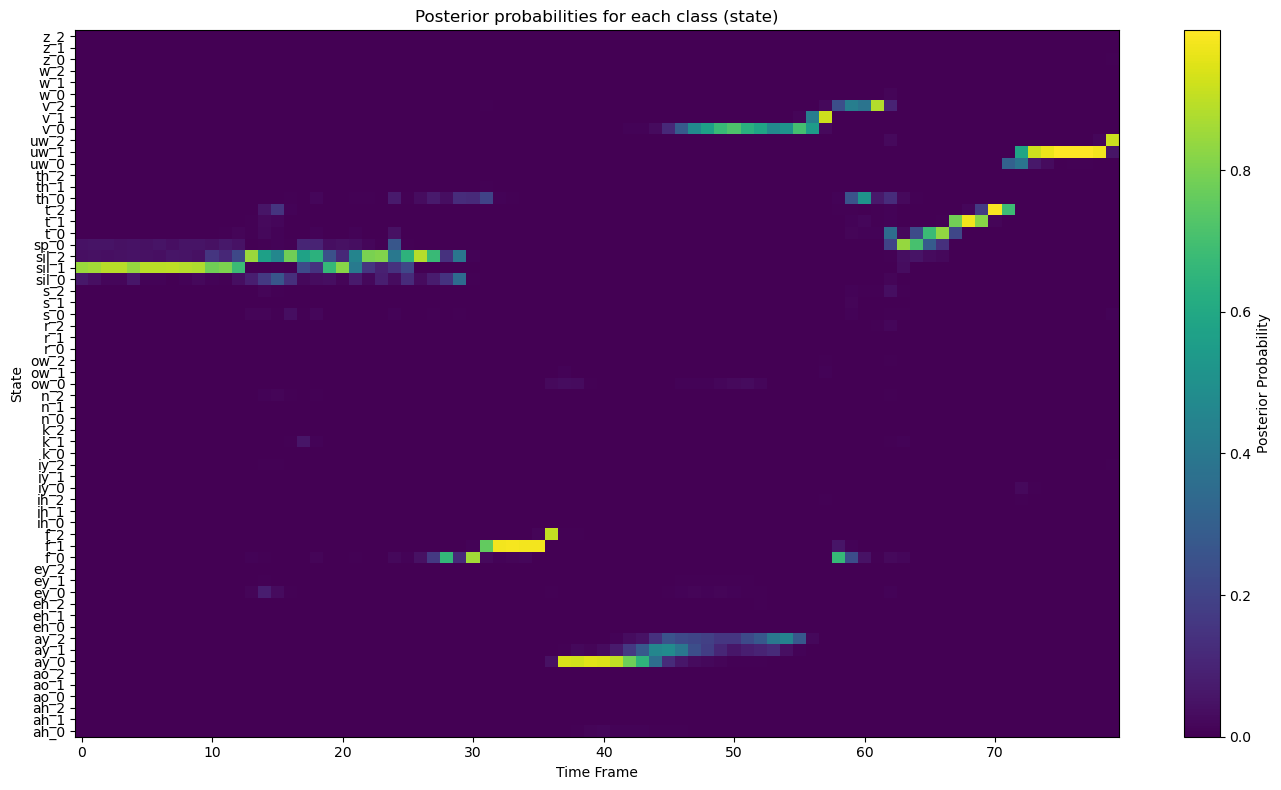

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.imshow(posteriors.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Posterior Probability')
plt.ylabel('State')
plt.xlabel('Time Frame')
plt.title('Posterior probabilities for each class (state)')
plt.yticks(ticks=np.arange(len(stateList))[::1], labels=stateList[::1])
plt.tight_layout()
plt.show()

In [12]:
print([stateList[idx] for idx in example_target])
print([stateList[idx] for idx in np.argmax(posteriors, 1)])

['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'f_0', 'f_0', 'f_0', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_2', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_1', 'ay_1', 'ay_1', 'ay_1', 'ay_1', 'ay_2', 'v_0', 'v_0', 'v_0', 'v_0', 'v_0', 'v_0', 'v_0', 'v_1', 'v_1', 'v_2', 'v_2', 'v_2', 'v_2', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 't_0', 't_1', 't_1', 't_2', 't_2', 'uw_0', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_1', 'uw_2']
['sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_1', 'sil_1', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'f_0', 'sil_2', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_2', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'ay_0', 'a

# frame-by-frame at the state level

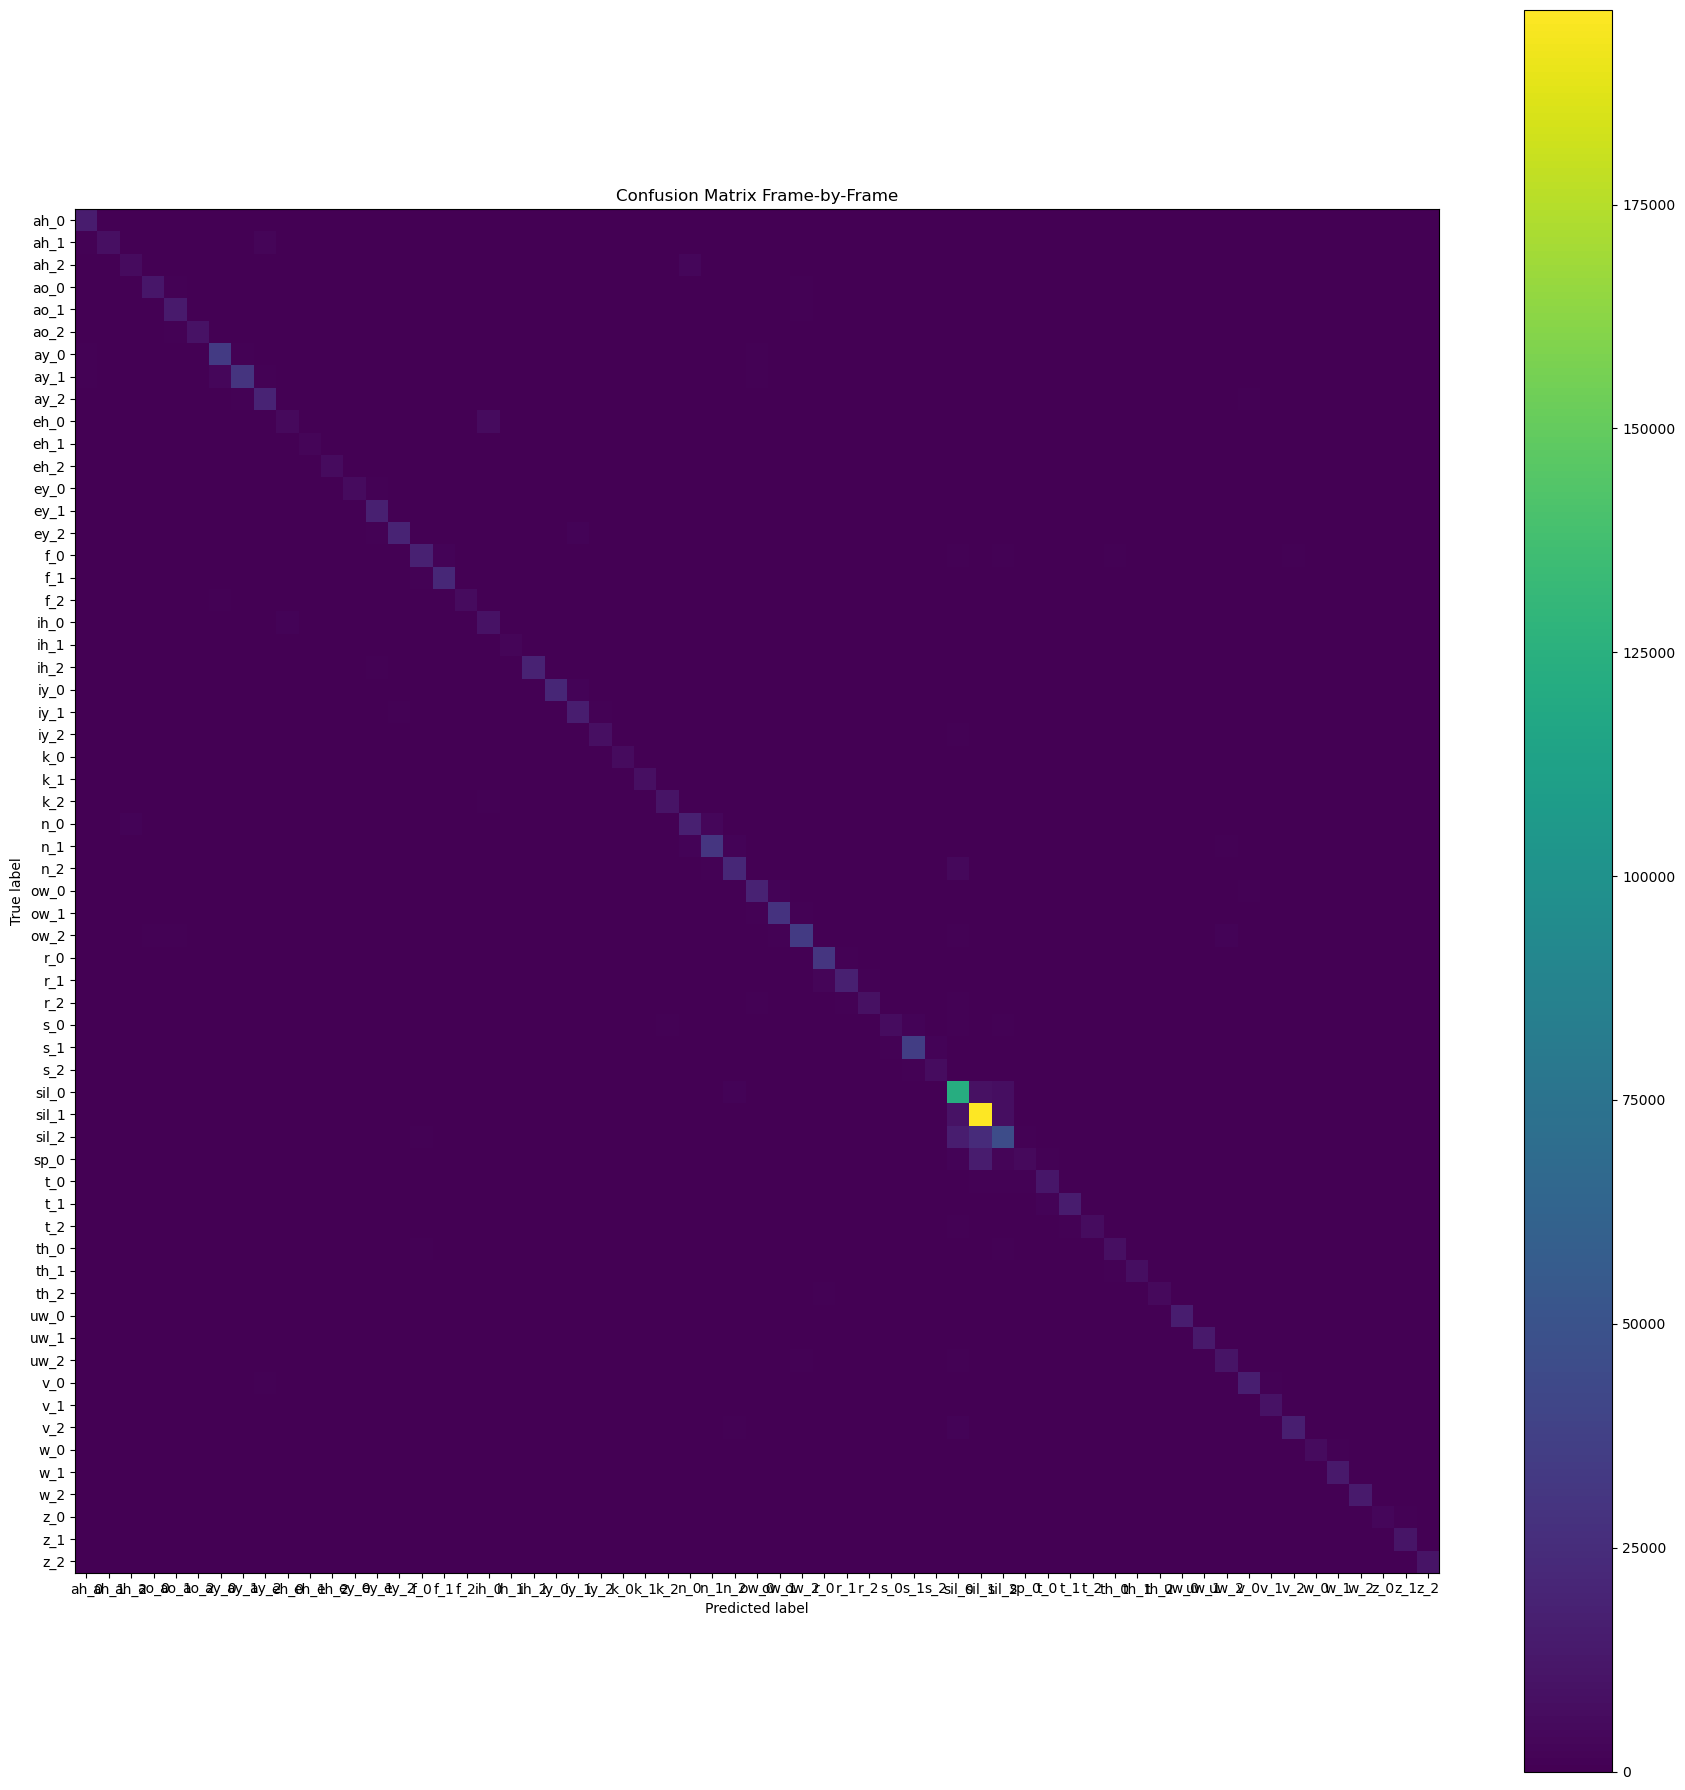

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_M = confusion_matrix(test_y_tensor, predicted)
confusion_D = ConfusionMatrixDisplay(confusion_matrix=confusion_M, display_labels=stateList)
fig, ax = plt.subplots(figsize=(18, 18))
confusion_D.plot(include_values=False,ax=ax)

plt.title("Confusion Matrix Frame-by-Frame")
plt.tight_layout()
plt.show()

# frame-by-frame at the phoneme level

 Frame accuracy at phoneme level: 0.8620


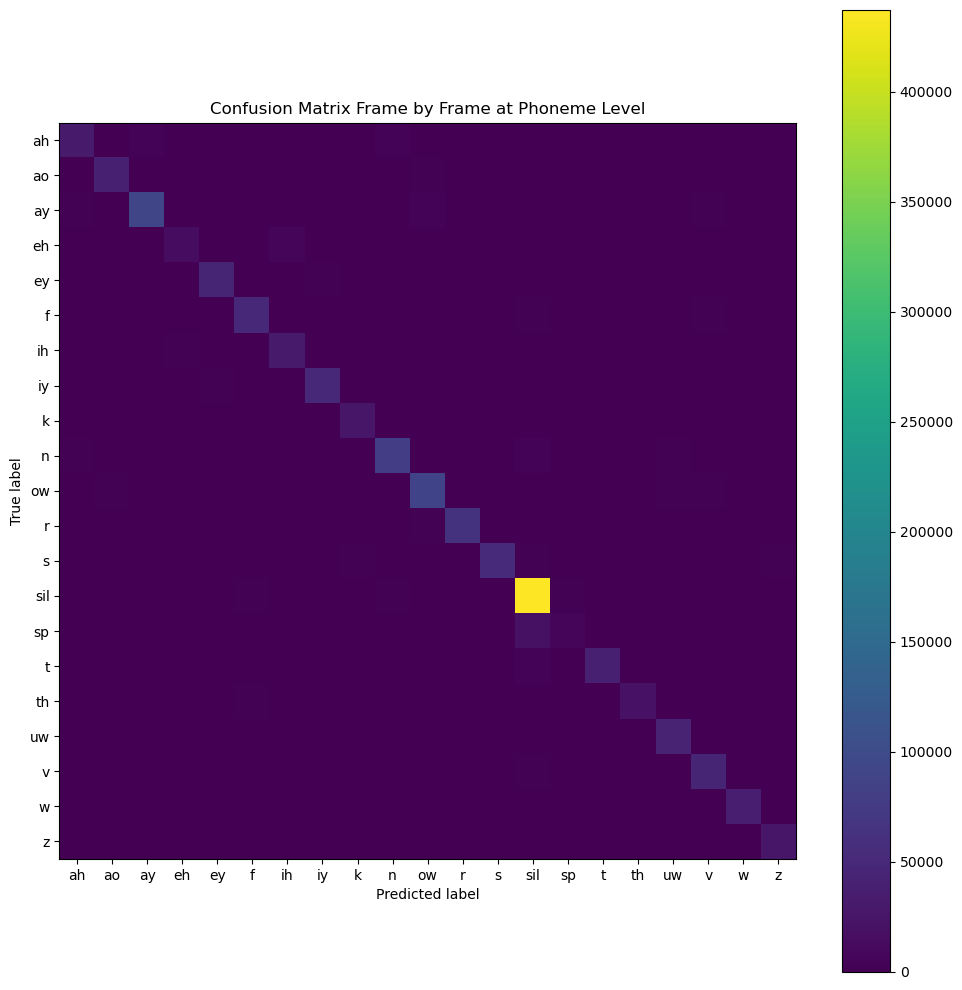

In [14]:
phoneList = [state.split("_")[0] for state in stateList]
phone_predict = [phoneList[idx] for idx in predicted.numpy()]
phone_y       = [phoneList[idx] for idx in test_y_tensor.numpy()]

accuracy_ph = np.mean(np.array(phone_predict) == np.array(phone_y))
print(f" Frame accuracy at phoneme level: {accuracy_ph:.4f}")

labels = sorted(set(phoneList))
confusion_D_F = confusion_matrix(phone_y, phone_predict)
display_F = ConfusionMatrixDisplay(confusion_matrix=confusion_D_F, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
display_F.plot(include_values=False, ax=ax)
plt.title("Confusion Matrix Frame by Frame at Phoneme Level")
plt.tight_layout()
plt.show()

In [15]:
stateList

['ah_0',
 'ah_1',
 'ah_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'eh_0',
 'eh_1',
 'eh_2',
 'ey_0',
 'ey_1',
 'ey_2',
 'f_0',
 'f_1',
 'f_2',
 'ih_0',
 'ih_1',
 'ih_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'k_0',
 'k_1',
 'k_2',
 'n_0',
 'n_1',
 'n_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'r_0',
 'r_1',
 'r_2',
 's_0',
 's_1',
 's_2',
 'sil_0',
 'sil_1',
 'sil_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'th_0',
 'th_1',
 'th_2',
 'uw_0',
 'uw_1',
 'uw_2',
 'v_0',
 'v_1',
 'v_2',
 'w_0',
 'w_1',
 'w_2',
 'z_0',
 'z_1',
 'z_2']

# edit distance at the state level:

In [16]:
state_pred = [stateList[idx] for idx in predicted.numpy()]
state_true = [stateList[idx] for idx in test_y_tensor.numpy()]

def mergestate(state_list):
    merged = [state_list[0]]
    for item in state_list[1:]:
        if item != merged[-1]:
            merged.append(item)
    return merged

merged_pred_state = mergestate(state_pred)
merged_true_state = mergestate(state_true)
merged_pred_state[:20]



['sil_1',
 'sil_2',
 'sil_1',
 'sil_2',
 'f_0',
 'sil_2',
 'f_0',
 'f_1',
 'f_2',
 'ay_0',
 'ay_1',
 'v_0',
 'v_1',
 'f_0',
 'v_2',
 'th_0',
 'v_2',
 't_0',
 'sp_0',
 't_0']

In [31]:
merged_true_state[:20]

['sil_0',
 'sil_1',
 'sil_2',
 'f_0',
 'f_1',
 'f_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'v_0',
 'v_1',
 'v_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'uw_0',
 'uw_1',
 'uw_2',
 's_0']

In [17]:
import editdistance

distance = editdistance.eval(merged_pred_state, merged_true_state)
PER = distance / len(merged_true_state)
print(f"Edit distance at the state level: {PER:.4f}")

Edit distance at the state level: 0.4237


# edit distance at the phoneme level:

In [18]:
merged_pred_phone = mergestate(phone_predict)
merged_true_phone = mergestate(phone_y)

In [19]:
merged_pred_phone[:20]

['sil',
 'f',
 'sil',
 'f',
 'ay',
 'v',
 'f',
 'v',
 'th',
 'v',
 't',
 'sp',
 't',
 'uw',
 's',
 'ih',
 'eh',
 'ih',
 'k',
 's']

In [20]:


distance = editdistance.eval(merged_pred_phone, merged_true_phone)
PER = distance / len(merged_true_phone)
print(f"Edit distance at the phone level: {PER:.4f}")


Edit distance at the phone level: 0.8440
